# Calculating Accumulated Growing Degree Days in Hawaii in 2020
"Growing degree days are a measure of heat accumulation used by horticulturists, gardeners, and farmers to predict plant and animal development rates"
"GDDs are calculated each day as maximum temperature plus the minimum temperature divided by 2, minus the base temperature. GDUs are accumulated by adding each day's GDs contribution as the season progresses." - Wiki [link](https://en.wikipedia.org/wiki/Growing_degree-day)

-------  
### Workflow :  
* [1. Create Multidimensional Raster](#create)
* [2. Calculate Growing Degrees](#gd)
* [3. Calculate Accumulated Growing Degree Days](#gdd)
* [4. Persist Output](#save)

In [21]:
# Import necessary modules and packages
import arcpy, json
from arcpy.ia import * 

# Check out extension
arcpy.CheckOutExtension('ImageAnalyst') 

# Define input and output data path
# Data source: http://daymet.ornl.gov/
# Data citation: Oak Ridge National Laboratory Distributed Active Archive Center (ORNL DAAC) https://daac.ornl.gov/
data_folder = r"C:\DevSummit2022\data\daymet"
out_folder = r"C:\DevSummit2022\out"

# Set environments
arcpy.env.overwriteOutput = True
arcpy.env.scratchWorkspace = out_folder
arcpy.env.workspace = out_folder

### <a id = "create">1. Create Multidimensional Raster</a>

#### Daily maximum temperature

In [22]:
# Create tmax_raster 
tmax_raster = arcpy.Raster(data_folder + "\\tmax_2020.nc", True) 
tmax_raster.variables

['tmax(StdTime=365)']

In [23]:
# load multidimensional information for tmax_raster raster object
info = json.loads(tmax_raster.mdinfo)
print(json.dumps(info, indent=2))

{
  "variables": [
    {
      "name": "tmax",
      "unit": "degrees C",
      "attributes": {
        "long_name": "daily maximum temperature",
        "missing_value": "-9999",
        "coordinates": "time y x ",
        "cell_methods": "area: mean time: maximum",
        "_ChunkSizes": "1"
      },
      "dimensions": [
        {
          "name": "StdTime",
          "field": "StdTime",
          "unit": "ISO8601",
          "interval": 1,
          "hasRegularIntervals": true,
          "intervalUnit": "Days",
          "extent": [
            "2020-01-01T12:00:00",
            "2020-12-30T12:00:00"
          ],
          "hasRanges": false,
          "values": [
            "2020-01-01T12:00:00",
            "2020-01-02T12:00:00",
            "2020-01-03T12:00:00",
            "2020-01-04T12:00:00",
            "2020-01-05T12:00:00",
            "2020-01-06T12:00:00",
            "2020-01-07T12:00:00",
            "2020-01-08T12:00:00",
            "2020-01-09T12:00:00",
       

}


#### Daily minimum temperature

In [24]:
# Create tmin_raster 
tmin_raster = arcpy.Raster(data_folder + "\\tmin_2020.nc", True) 
tmin_raster.variables

['tmin(StdTime=365)']

In [25]:
info = json.loads(tmin_raster.mdinfo)
print(json.dumps(info, indent=2))

{
  "variables": [
    {
      "name": "tmin",
      "unit": "degrees C",
      "attributes": {
        "long_name": "daily minimum temperature",
        "missing_value": "-9999",
        "coordinates": "time y x ",
        "cell_methods": "area: mean time: minimum",
        "_ChunkSizes": "1"
      },
      "dimensions": [
        {
          "name": "StdTime",
          "field": "StdTime",
          "unit": "ISO8601",
          "interval": 1,
          "hasRegularIntervals": true,
          "intervalUnit": "Days",
          "extent": [
            "2020-01-01T12:00:00",
            "2020-12-30T12:00:00"
          ],
          "hasRanges": false,
          "values": [
            "2020-01-01T12:00:00",
            "2020-01-02T12:00:00",
            "2020-01-03T12:00:00",
            "2020-01-04T12:00:00",
            "2020-01-05T12:00:00",
            "2020-01-06T12:00:00",
            "2020-01-07T12:00:00",
            "2020-01-08T12:00:00",
            "2020-01-09T12:00:00",
       

}


### <a id = "gd">2. Calculate Growing Degrees (GDs), 12 degree based</a>

In [26]:
# Allow mathematical algebra among different variables
arcpy.env.matchMultidimensionalVariable = False

In [27]:
# Calculate the difference between the average temparture and the base temperature
# Base temperature is taken as 12 °C, an appropriate value for sugarcane (Inman-Bamber, 1994).
base_temperature = 12 
temp_growing_degrees = (tmax_raster + tmin_raster)/2 - base_temperature

In [28]:
# Mask negative values to zero
growing_degrees = Remap(temp_growing_degrees, input_ranges=[-100, 0], output_values = [0], allow_unmatched = True)
growing_degrees.variables

['*(StdTime=365)']

#### Visualize

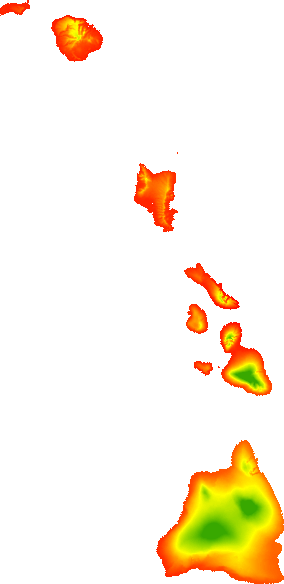

In [29]:
# Choose one slice for visulization 
# Visualizing 06/01/2020
growing_degree_slice = Subset(growing_degrees, dimension_definitions = {"StdTime": "2020-06-01T12:00:00"})
# Define the render
rendered_growing_degree = Render(growing_degree_slice, rendering_rule = {"min": 0, "max": 15}, colormap = "slope")
rendered_growing_degree.exportImage(width = 400)
rendered_growing_degree

### <a id = "gdd">3. Calculate Accumulated Growing Degree Days</a>

In [30]:
# Calculate the accumulated annual growing degree days
accumulated_growing_degrees = Aggregate(growing_degrees, dimension_name = "StdTime", raster_function = "Sum")

In [31]:
# Check its dimension values
accumulated_growing_degrees.getDimensionValues("", "StdTime")

[('2020-01-01T12:00:00+00:00', '2020-12-30T12:00:00+00:00')]

### <a id = "save">4. Persist output</a>

In [32]:
accumulated_growing_degrees.save("AccumulatedGDDHawaii_2020.crf")

References:

Inman-Bamber, N.G., 1994. Temperature and seasonal effects on canopy development and light interception of sugarcane. Field Crops Research, 36(1), pp.41-51.

Thornton, P.E. and S.W. Running. 1999. An improved algorithm for estimating incident daily solar radiation from measurements of temperature, humidity, and precipitation. Agriculture and Forest Meteorology. 93:211-228